In [1]:
#https://docs.zama.ai/concrete-ml/stable/user/advanced_examples/XGBClassifier.html

# XGBoost Classifier (and Random Forest Classifier)

In [2]:
import time
import platform
import warnings

# For warnings in xgboost.sklearn
warnings.simplefilter(action="ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import numpy
from matplotlib.colors import ListedColormap
from sklearn.datasets import fetch_openml, make_circles
from sklearn.ensemble import RandomForestClassifier as SklearnRandomForestClassifier
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost.sklearn import XGBClassifier as SklearnXGBClassifier

from concrete.ml.sklearn import RandomForestClassifier as ConcreteRandomForestClassifier
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier

%matplotlib inline

# Define if you want to run XGBoost or Random Forest classifier

In [3]:
#which_classifier = "XGBoost"
which_classifier = "RF"

if which_classifier == "XGBoost":
    sklearn_classifier = SklearnXGBClassifier
    concrete_classifier = ConcreteXGBClassifier
    fit_extra_param = {"eval_metric": "logloss"}
else:
    sklearn_classifier = SklearnRandomForestClassifier
    concrete_classifier = ConcreteRandomForestClassifier
    fit_extra_param = {}

# Let’s define some data to classify

In [4]:
X, y = make_circles(n_samples=1000, noise=0.1, factor=0.6, random_state=0)

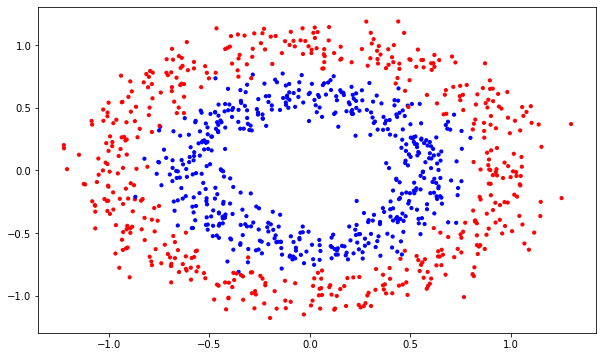

In [5]:
# Define the figure size and color
plt.figure(figsize=(10, 6))
cm_bright = ListedColormap(["#FF0000", "#FFFFFF", "#0000FF"])

plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=cm_bright)
plt.show()

In [6]:
n_estimators = 50
max_depth = 4
n_bits = 6

In [7]:
n_jobs_xgb = 1
n_jobs_gridsearch = -1

# There are problems on macOS with multi-jobs in GridSearch so let's switch
if platform.system() == "Darwin":
    n_jobs_xgb = -1
    n_jobs_gridsearch = 1

# This is how to classify with scikit-learn

In [8]:
sklearn_clf = sklearn_classifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs_xgb)
tic = time.perf_counter()
sklearn_clf.fit(X, y, **fit_extra_param)
toc = time.perf_counter()
print(f"Classic sklearn model fit {toc-tic:0.4f} seconds")

Classic sklearn model fit 0.0666 seconds


# And this is how to classify with Concrete ML: pretty much the same

In [9]:
concrete_clf = concrete_classifier(
    n_bits=n_bits, n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs_xgb
)
tic = time.perf_counter()
concrete_clf.fit(X, y)
toc = time.perf_counter()
print(f"FHE sklearn model fit {toc-tic:0.4f} seconds")

FHE sklearn model fit 0.2071 seconds


# Now, let’s see the classifications

In [10]:
def plot_contour(clf, X, y):
    # Create a grid will lots of point to plot the countour of the decision function
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    grid_x, grid_y = numpy.meshgrid(
        numpy.arange(x_min, x_max, 0.1), numpy.arange(y_min, y_max, 0.1)
    )

    # Predict the function value on the grid
    grid_z = clf.predict_proba(numpy.c_[grid_x.ravel(), grid_y.ravel()])[:, 1]

    # grid_z = clf.predict(numpy.c_[grid_x.ravel(), grid_y.ravel()])
    grid_z = grid_z.reshape(grid_x.shape)

    # Define the plot size
    plt.figure(figsize=(10, 6))

    # Plot the contour and training examples
    plt.contourf(grid_x, grid_y, grid_z, cmap=cm_bright, alpha=0.2)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1, cmap=cm_bright)
    plt.show()

With scikit-learn

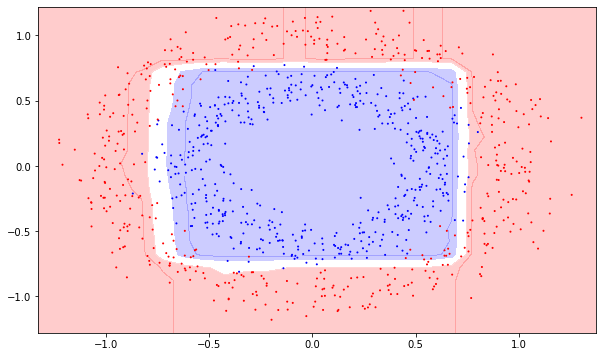

In [11]:
plot_contour(sklearn_clf, X, y)

And with Concrete ML

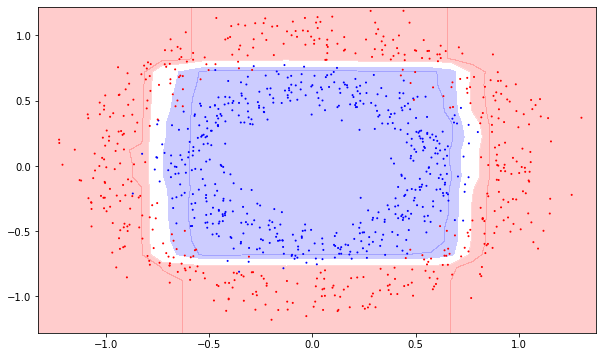

In [12]:
plot_contour(concrete_clf, X, y)

# And now, on the diabetes datasets¶

In [13]:
X, y = fetch_openml(name="diabetes", as_frame=False, cache=True, return_X_y=True)
y[y == "tested_positive"] = 1
y[y == "tested_negative"] = 0
y = y.astype(numpy.int)

In [14]:
X.shape

(768, 8)

In [15]:
# shapeate scorer with the MCC metric
grid_scorer = make_scorer(matthews_corrcoef, greater_is_better=True)
n_estimators_list = [1, 5, 10, 20] #+ [20 * i for i in range(2, 11)] + [50 * i for i in range(5, 11)]

In [16]:
param_grid = {
    "n_bits": [6],
    "max_depth": [2],
    "n_estimators": n_estimators_list,
}
concrete_clf = concrete_classifier(n_jobs=n_jobs_xgb)

tic = time.perf_counter()
gs_concrete = GridSearchCV(
    concrete_clf, param_grid, cv=5, scoring=grid_scorer, verbose=1, n_jobs=n_jobs_gridsearch
).fit(X, y)
toc = time.perf_counter()
print(f"FHE sklearn model fit {toc-tic:0.4f} seconds")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
FHE sklearn model fit 4.7494 seconds


In [17]:
warnings.filterwarnings("ignore")
param_grid = {
    "max_depth": [2],
    "n_estimators": n_estimators_list,
}
sklearn_clf = sklearn_classifier(n_jobs=n_jobs_xgb)
tic = time.perf_counter()
gs_sklearn = GridSearchCV(
    sklearn_clf, param_grid, cv=5, scoring=grid_scorer, verbose=1, n_jobs=n_jobs_gridsearch
).fit(X, y, **fit_extra_param)
toc = time.perf_counter()
print(f"Classic sklearn model fit {toc-tic:0.4f} seconds")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Classic sklearn model fit 0.1403 seconds


In [18]:
# Print mean time fit and std time fit for both models
print(
    f"Mean time fit sklearn: {numpy.mean(gs_sklearn.cv_results_['mean_fit_time']):.2f}s,"
    f" std time fit sklearn: {numpy.std(gs_sklearn.cv_results_['mean_fit_time']):.2f}s"
)
print(
    f"Mean time fit concrete: {numpy.mean(gs_concrete.cv_results_['mean_fit_time']):.2f}s,"
    f"std time fit concrete: {numpy.std(gs_concrete.cv_results_['mean_fit_time']):.2f}s"
)

# Print best score for both models
print(f"Best MCC score sklearn: {gs_sklearn.best_score_:.2f}")
print(f"Best MCC score concrete: {gs_concrete.best_score_:.2f}")

Mean time fit sklearn: 0.02s, std time fit sklearn: 0.01s
Mean time fit concrete: 0.33s,std time fit concrete: 0.05s
Best MCC score sklearn: 0.44
Best MCC score concrete: 0.40


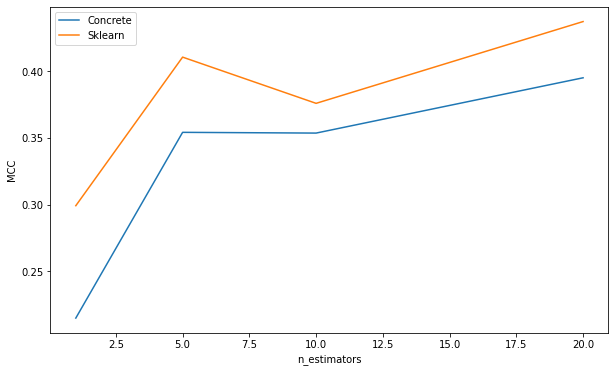

In [19]:
# Define the figure size
plt.figure(figsize=(10, 6))

# Plot the mean_test_score of both model along the n_estimators hyper parameter
plt.plot(
    gs_concrete.cv_results_["param_n_estimators"],
    gs_concrete.cv_results_["mean_test_score"],
    label="Concrete",
)
plt.plot(
    gs_sklearn.cv_results_["param_n_estimators"],
    gs_sklearn.cv_results_["mean_test_score"],
    label="Sklearn",
)
plt.xlabel("n_estimators")
plt.ylabel("MCC")
plt.legend()
plt.show()

# FHE Execution

Now that we have the best hyper parameters for our XGBoost model, we want to use it in FHE.

In [20]:
# Get best hyper parameters out of gs_concrete
best_params_concrete = gs_concrete.best_params_
print(f"Best params for Concrete {which_classifier}: {best_params_concrete}")
best_params_sklearn = gs_sklearn.best_params_
print(f"Best params Sklearn {which_classifier}: {best_params_sklearn}")

# Train concrete and sklearn xgb  with best hyper parameters
concrete_clf = concrete_classifier(**best_params_concrete, n_jobs=n_jobs_xgb)
sklearn_clf = sklearn_classifier(**best_params_sklearn, n_jobs=n_jobs_xgb)

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
concrete_clf.fit(X_train, y_train)
sklearn_clf.fit(X_train, y_train, **fit_extra_param)

Best params for Concrete RF: {'max_depth': 2, 'n_bits': 6, 'n_estimators': 20}
Best params Sklearn RF: {'max_depth': 2, 'n_estimators': 20}


RandomForestClassifier(max_depth=2, n_estimators=20, n_jobs=1)

In [21]:
# Compile the model using the training data (this can take several minutes)
tic = time.perf_counter()
concrete_clf.compile(X_train)
toc = time.perf_counter()
print(f"FHE sklearn model compile {toc-tic:0.4f} seconds")

FHE sklearn model compile 2.9314 seconds


In [22]:
# Now that the model is compiled, we can compute some examples in FHE.
# We will use 10 examples from the test set.
n_sample_to_test_fhe = 50#10

# Set numpy random seed
numpy.random.seed(42)

# Pick n_sample_to_test_fhe random samples from the test set
idx_test = numpy.random.choice(X_test.shape[0], n_sample_to_test_fhe, replace=False)
X_test_fhe = X_test[idx_test]
y_test_fhe = y_test[idx_test]

In [23]:
# Get the equivalent sklearn (fp32) predictions
tic = time.perf_counter()
y_preds_sklearn = sklearn_clf.predict(X_test_fhe)
toc = time.perf_counter()
time_sklearn_predict=toc-tic
print(f"sklearn model predict {time_sklearn_predict:0.4f} seconds")


sklearn model predict 0.0027 seconds


In [24]:
# Now predict in clear quantized
tic = time.perf_counter()
y_preds_clear = concrete_clf.predict(X_test_fhe)
toc = time.perf_counter()
time_concrete_clear_predict=toc-tic
print(f"FHE sklearn model clear predict {time_concrete_clear_predict:0.4f} seconds")

FHE sklearn model clear predict 0.0014 seconds


In [25]:
# First predict in FHE (WARNING: this can take several minutes)
tic = time.perf_counter()
y_preds_fhe = concrete_clf.predict(X_test_fhe, execute_in_fhe=True)
toc = time.perf_counter()
time_concrete_fhe_predict_1=toc-tic
print(f"FHE sklearn model predict {time_concrete_fhe_predict_1/60:0.4f} minutes")

FHE sklearn model predict 20.9779 minutes


In [26]:
# second predict in FHE 
tic = time.perf_counter()
y_preds_fhe = concrete_clf.predict(X_test_fhe, execute_in_fhe=True)
toc = time.perf_counter()
time_concrete_fhe_predict_2=toc-tic
print(f"FHE sklearn model 2nd predict {time_concrete_fhe_predict_2/60:0.4f} minutes")

FHE sklearn model 2nd predict 17.8921 minutes


In [27]:
print(f"Classic sklearn model prediction {time_sklearn_predict:0.4f} seconds")
print(f"FHE sklearn model clear predict {time_concrete_clear_predict:0.4f} seconds ({time_concrete_clear_predict/time_sklearn_predict:0.1f} times longer than sklearn model")
print(f"FHE sklearn model predict {time_concrete_fhe_predict_1/60:0.4f} minutes, {time_concrete_fhe_predict_1/X_test_fhe.shape[0]:0.1f}s per record ({time_concrete_fhe_predict_1/time_sklearn_predict:0.1f} times longer than sklearn model")
print(f"FHE sklearn model 2nd predict {time_concrete_fhe_predict_2/60:0.4f} minutes, {time_concrete_fhe_predict_2/X_test_fhe.shape[0]:0.1f}s per record ({time_concrete_fhe_predict_2/time_sklearn_predict:0.1f} times longer than sklearn model")

Classic sklearn model prediction 0.0027 seconds
FHE sklearn model clear predict 0.0014 seconds (0.5 times longer than sklearn model
FHE sklearn model predict 20.9779 minutes, 25.2s per record (462219.4 times longer than sklearn model
FHE sklearn model 2nd predict 17.8921 minutes, 21.5s per record (394227.5 times longer than sklearn model
